# Lab 1d: K-Means Clustering Analysis of a Heart Failure Clinical Dataset
In this lab, we will cluster a dataset describing the clinical risk factors linked with death from heart disease using [the K-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering). In this dataset, several risk factors (features) are measured per patient (some of these features are continuous, some are categorical), along with the binary clinical outcome (target variable) `{death | not death}.` 

Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

### Tasks
* __Setup, Data, Constants (10 min)__: Let's take 10 minutes to review the dataset we'll explore today and set up some values we'll use in the other tasks. We'll load the data and do some initial _data munging_ (also called [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling)) to get the clinical dataset in a form that we'll use in our analysis.
* __Task 1: Cluster (20 min)__: In this task, you will set up the clustering problem and execute the clustering algorithm on our dataset using a default value for parameters (such as the number of clusters $K$). We'll check that the _energy_ of the system decreases to a minimum.
* __Task 2: Analysis of clustering results (20 min)__: Now that we have clustered the data (using the specified number of clusters that we computed), let's take some time to explore what's in each cluster and what the clinical data says about heart disease and heart disease risk factors.

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [172]:
include("Include.jl"); # this executes the Include.jl file - what does that do?

### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the Level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` otherwise.

We'll load this data as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

In [174]:
originaldataset = CSV.read(joinpath(_PATH_TO_DATA, "heart_failure_clinical_records_dataset.csv"), DataFrame)

Row,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64
1,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
2,55.0,0,7861,0,38,0,263358.0,1.1,136,1,0,6,1
3,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
4,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
5,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
6,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
7,75.0,1,246,0,15,0,127000.0,1.2,137,1,0,10,1
8,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1
9,65.0,0,157,0,65,0,263358.0,1.5,138,0,0,10,1


We know from lecture that [the K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) works on [an instance of a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}) and not [a `DataFrame` instance](https://dataframes.juliadata.org/stable/). Thus, we need to convert the data to [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}). In addition, there are several ways we can pretreat the data to make the clustering easier.

In [176]:
(D, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end

    # remove categorical cols -
    # D̂₂ = D̂[:,index_to_z_scale]; # z-scaled data, no label, no categorical
    D̂₂ = D̂[:,1:end-1]; # z-scaled data, no label, with unscaled categorical
    #D̂₂ = D̂[:,1:end-1]; # raw (unscaled) data, no label
    
    D̂₂, treated_dataset
end;

In [177]:
D

299×12 Matrix{Float64}:
  1.19095    -1.0   0.000165451  -1.0  …  -1.50152     1.0  -1.0  -1.62678
 -0.490457   -1.0   7.50206      -1.0     -0.141739    1.0  -1.0  -1.60101
  0.350246   -1.0  -0.449186     -1.0     -1.72815     1.0   1.0  -1.58812
 -0.910808    1.0  -0.485257     -1.0      0.0848915   1.0  -1.0  -1.58812
  0.350246    1.0  -0.434757      1.0     -4.67434    -1.0  -1.0  -1.57524
  2.452       1.0  -0.551217     -1.0  …  -1.04826     1.0   1.0  -1.57524
  1.19095     1.0  -0.346124     -1.0      0.0848915   1.0  -1.0  -1.54947
 -0.0701056   1.0  -0.275011      1.0     -1.27489     1.0   1.0  -1.54947
  0.350246   -1.0  -0.437849     -1.0      0.311522   -1.0  -1.0  -1.54947
  1.6113      1.0  -0.47289      -1.0     -0.821629    1.0   1.0  -1.54947
  1.19095     1.0  -0.516176     -1.0  …  -1.27489     1.0   1.0  -1.54947
  0.098035   -1.0  -0.361583     -1.0      0.764782    1.0   1.0  -1.54947
 -1.33116     1.0   0.411384     -1.0      0.0848915   1.0  -1.0  -1.53659
 

Let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [179]:
n = nrow(originaldataset); # how many example data points do we have?
m = size(D,2); # number of features (number of cols)
maxiter = 100000; # maximum iterations
K = 3; # number of clusters. What number should we pick?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

Finally, let's set up the color dictionary for the visualizations in the lecture. The keys of the `my_color_dictionary::Dict{Int64,RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index.

In [181]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#0077b6";
my_color_dictionary[3] = colorant"#00b4d8";
my_color_dictionary[4] = colorant"#ffc300";
my_color_dictionary[5] = colorant"#e36414";

## Task 1: Build a K-means model and cluster the data
We've developed an [initial K-means implementation](src/Cluster.jl) based on [our pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-1/L1c/docs/L1c-5820-S2025.pdf). Let's explore how this implementation performs on our sample dataset. There is [already a good clustering package `Clustering.jl` that is available](https://github.com/JuliaStats/Clustering.jl) that exports [a `K-means` function](https://juliastats.org/Clustering.jl/stable/kmeans.html). However, in this demo, we'll use our implementation.
* __Problem model__: Build [a `MyNaiveKMeansClusteringAlgorithm` instance](src/Types.jl), which holds information about the clustering, i.e., the number of clusters `K::Int,` information about the dataset such as the number of features `m::Int,` and the number of points `n::Int,` and stopping criteria information such as the maximum number of iterations `maxiter::Int` and tolerance `ϵ::Float64`. We'll store this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.

This is an example of [a factory type pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), which uses [a `build(...)` method](src/Factory.jl) to construct and configure a complex object, i.e., set values for the properties on the model that must be computed. The [`build(...)` method](src/Factory.jl) takes the type of thing we want to build as the first argument, and the data required to construct the object (encoded [in a `NamedTupe` type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple)) as the second argument.

In [183]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 1.0, # scale of the data
));

### Initial clustering values
The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in, as well as two derived fields that we computed in [the `build(...)` method](src/Factory.jl), the centroids and initial assignments: 
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_1, \dots, \mu_K$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the clustered index that each data point is assigned to. We initialize the assignments randomly.

What is in the `centroids` and `assignments` fields of your model?

In [185]:
model.centroids

Dict{Int64, Vector{Float64}} with 3 entries:
  2 => [0.638288, 0.297669, 0.655765, 0.772564, 0.137616, 0.950641, 0.963514, 0…
  3 => [0.772324, 0.208146, 0.400605, 0.695493, 0.333715, 0.780992, 0.937528, 0…
  1 => [0.023015, 0.111782, 0.153323, 0.35678, 0.300139, 0.302069, 0.606258, 0.…

### Execute the Clustering
We'll call [the `cluster(...)` method](src/Cluster.jl) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](src/Cluster.jl) takes a few arguments (and returns the clustering results):

* __Data__: `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the feature vectors $\mathbf{x}\in\mathbb{R}^{m}$ as columns. Its values can be any subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* __Model__: `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, i.e.,  the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, the model can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why an abstract generic type?__ Suppose we have different K-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* __Verbose (optional)__: `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration.
* __Measure (optional)__:`d::Any`. The optional distance argument is the $d(p,q)$ function and can be used to change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl); by default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance). 

The [`cluster(...)` method](src/Cluster.jl) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `results::NamedTuple.`

In [187]:
result = cluster(D, model, verbose = true); # cluster the data, save each stage to disk in the tmp folder (verbose = true)

In [188]:
result.assignments

299-element Vector{Int64}:
 3
 1
 3
 3
 3
 3
 3
 2
 2
 3
 3
 2
 1
 ⋮
 1
 1
 2
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [189]:
result.centroids

Dict{Int64, Vector{Float64}} with 3 entries:
  2 => [0.020246, 0.0344828, -0.22212, -0.103448, 0.34039, 0.482759, 0.120696, …
  3 => [0.955934, 0.0909091, -0.158457, -0.409091, -0.114606, -0.5, -0.249014, …
  1 => [-0.319494, -0.352518, 0.235525, -0.136691, -0.247788, -0.884892, -0.021…

Finally, how balanced are the clusters? Let's compute the fraction of our patient population in each cluster, and display this information in a table [using the `pretty_table(...)` function exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl)

In [191]:
let

    df = DataFrame(); # container for the fraction data
    
    for k ∈ 1:K # iterate over the number of clusters
        Nᵢ = findall(x-> x == k, result.assignments) |> length;
        row_df = (
            cluster = k,
            fraction = (Nᵢ/n)
        );
        push!(df, row_df)
    end

    pretty_table(df, tf=tf_simple)
end

========== ===========
  cluster   fraction 
    Int64    Float64 
========== ===========
        1   0.464883
        2    0.38796
        3   0.147157
========== ===========


### Check: Energy decrease?
The problem of K-means clustering can be formulated as an optimization problem, 
where the objective is to minimize the sum of squared distances between each data point and its assigned cluster centroid. If we think about this objective in terms of a pseudo-energy $E(c_{1},\dots,c_{K})$, then we are looking for the cluster assignments that minimize the energy:
$$
\begin{equation}
\min_{c_{1},\dots,c_{K}} E\left(c_{1},\dots,c_{K}\right)= \sum_{j=1}^{K}\sum_{\mathbf{x}\in c_{j}}d(\mathbf{x},\mu_{j})^{2}\quad\text{where}\,\mu_{j} = |c_{j}|^{-1}\cdot\sum_{\mathbf{x}\in{c_{j}}}\mathbf{x}
\end{equation}
$$
where $d(\mathbf{x},\mu_{j})$ denotes the distance (similarity) between two vectors (in this case, a feature vector and the cluster centroid), 
and $|c_{\star}|$ denotes the number of elements in cluster $\star$. By default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) as our similarity measure. The K-means algorithm aims to find the optimal cluster assignments $\mathcal{C}$ and cluster centroids $\mu$ that minimize this objective function.

In [193]:
tmp = load(joinpath(_PATH_TO_TMP, "data-1.jld2"))

Dict{String, Any} with 3 entries:
  "centroids"   => Dict(2=>[0.638288, 0.297669, 0.655765, 0.772564, 0.137616, 0…
  "loopcount"   => 1
  "assignments" => [3, 1, 1, 2, 3, 2, 1, 2, 1, 3  …  2, 1, 3, 3, 1, 1, 2, 3, 3,…

In [194]:
energy_array = let

    number_of_iterations = result.loopcount; # how many iterations did we take to converge?
    energy_array = Array{Float64,1}(undef, number_of_iterations);
    

    for i ∈ 1:number_of_iterations
        tmp = load(joinpath(_PATH_TO_TMP, "data-$(i).jld2")); # returns a dictionary
        a = tmp["assignments"]; # get the assignment vector for this iteration
        μ = tmp["centroids"]; # get the cluster centroids for this iteration
        energy_array[i] = configurationenergy(D, a, μ);
    end

    # 0,1 scale the energy
    L = minimum(energy_array); # low value
    H = maximum(energy_array); # high value
    scaled_energy_array = Array{Float64,1}(undef, number_of_iterations);
    for i ∈ 1:number_of_iterations
       scaled_energy_array[i] = (energy_array[i] - L)/(H - L);
    end
    
    scaled_energy_array
end;

#### Visualize
`Unhide` the code block below to see how we plotted the scaled energy as a function of the number of iterations of our K-means implementation.

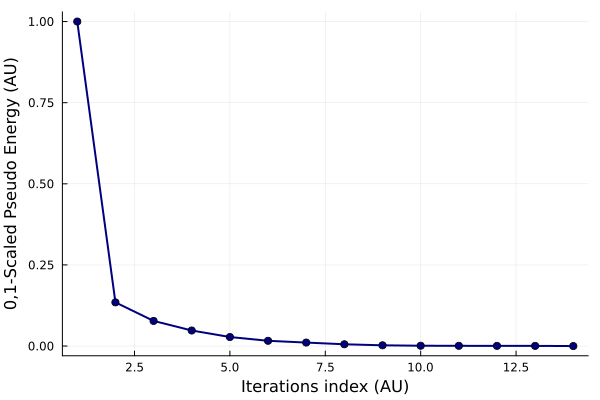

In [196]:
let

    iterations = range(1,stop=result.loopcount,step=1) |> collect; # iteration count vector
    plot(iterations,energy_array, lw=2, c=:navy, label="") 
    scatter!(iterations, energy_array, c=:navy, label="")
    xlabel!("Iterations index (AU)", fontsize=18)
    ylabel!("0,1-Scaled Pseudo Energy (AU)", fontsize=18)
end

### Method 1: Silhouette method
The silhouette method evaluates data consistency in clusters. The score ranges from -1 to 1; a high score means a data point fits well in its cluster but not in neighboring ones. The number of clusters $K$ is likely correct if most points score high. Conversely, many low scores suggest there may be too many or too few clusters. 
* The silhouette method is exported by [the `Clustering.jl` package](https://github.com/JuliaStats/Clustering.jl), so let's choose the buy side of the buy versus bill trade and use the prebuilt implementation of clustering and evaluation of the performance of the clustering. 

In [198]:
performance_array_silhouette = let

    number_of_clusters_to_explore = 10;
    KA = range(2,stop=number_of_clusters_to_explore, step=1) |> collect;
    tmp = Array{Float64,2}(undef, length(KA), 2);

    for i ∈ eachindex(KA)

        Kᵢ = KA[i]; # how many clusters?
        R = kmeans(transpose(D),  Kᵢ; maxiter=maxiter, display=:none) # sensitive to the choice of maxiter. # Clustering.jl use the transpose of our method
        M = R.centers # get the cluster centers
        a = assignments(R) # get the assignments of points to clusters
        value = clustering_quality(transpose(D), a; quality_index = :silhouettes)
        
        tmp[i,1] = Kᵢ;
        tmp[i,2] = value;
    end
    tmp
end;

In [199]:
performance_array_silhouette

9×2 Matrix{Float64}:
  2.0  0.177623
  3.0  0.155194
  4.0  0.182195
  5.0  0.151633
  6.0  0.169804
  7.0  0.154002
  8.0  0.165574
  9.0  0.148441
 10.0  0.154203

In [200]:
k₁ = let
    kopt = argmax(performance_array_silhouette[:,2]) |> j -> performance_array_silhouette[j,1]
    println("Predicted number of clusters by the silhouette method : $(kopt)")
    kopt;
end;

Predicted number of clusters by the silhouette method : 4.0


### Method 2: Calinski–Harabasz index (CHI)
The [Calinski–Harabasz index (CHI)](https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index), also known as the Variance Ratio Criterion, is a widely used metric for assessing the quality of clustering algorithms. Introduced by [Tadeusz Caliński and Jerzy Harabasz in 1974](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101), it evaluates the clustering performance by comparing the ratio of between-cluster variance to within-cluster variance, with higher values indicating better-defined clusters
* The CHI method is exported by [the `Clustering.jl` package](https://github.com/JuliaStats/Clustering.jl), so let's choose the buy side of the buy versus bill trade and use the prebuilt implementation of clustering and evaluation of the performance of the clustering. 

In [202]:
performance_array_CHI = let

    number_of_samples = size(D,1);
    number_of_features = size(D,2);
    number_of_clusters_to_explore = 10;
    KA = range(2,stop=number_of_clusters_to_explore, step=1) |> collect;
    tmp = Array{Float64,2}(undef, number_of_clusters_to_explore-1, 2);

    for i ∈ eachindex(KA)

        Kᵢ = KA[i]; # how many clusters?
        R = kmeans(transpose(D), Kᵢ; maxiter=maxiter, display=:none); # Clustering.jl use the transpose of our method
        M = R.centers # get the cluster centers
        a = assignments(R) # get the assignments of points to clusters
        value = clustering_quality(transpose(D), M, a; quality_index = :calinski_harabasz)
        
        tmp[i,1] = Kᵢ;
        tmp[i,2] = value;
    end
    tmp
end;

In [203]:
k₂ = let
    kopt = argmax(performance_array_CHI[:,2]) |> j -> performance_array_CHI[j,1]
    println("Predicted number of clusters by CHI: $(kopt)")
    kopt;
end;

Predicted number of clusters by CHI: 2.0


### Method 3: Xie Beni index (XBI)
The Xie-Beni index measures the ratio between the summed inertia of clusters and the minimum distance between cluster centers. See: 

* [M. Muranishi, K. Honda and A. Notsu, "Application of xie-beni-type validity index to fuzzy co-clustering models based on cluster aggregation and pseudo-cluster-center estimation," 2014 14th International Conference on Intelligent Systems Design and Applications, Okinawa, Japan, 2014, pp. 34-38, doi: 10.1109/ISDA.2014.7066274.](https://ieeexplore.ieee.org/document/7066274)
* The Xie-Beni method is exported by [the `Clustering.jl` package](https://github.com/JuliaStats/Clustering.jl), so let's choose the buy side of the buy versus bill trade and use the prebuilt implementation of clustering and evaluation of the performance of the clustering. 

In [205]:
performance_array_xie_beni = let

    number_of_samples = size(D,1);
    number_of_features = size(D,2);
    number_of_clusters_to_explore = 10;
    KA = range(2,stop=number_of_clusters_to_explore, step=1) |> collect;
    tmp = Array{Float64,2}(undef, number_of_clusters_to_explore-1, 2);

    for i ∈ eachindex(KA)

        Kᵢ = KA[i]; # how many clusters?
        R = kmeans(transpose(D), Kᵢ; maxiter=maxiter, display=:none); # Clustering.jl use the transpose of our method
        M = R.centers # get the cluster centers
        a = assignments(R) # get the assignments of points to clusters
        value = clustering_quality(transpose(D), M, a; quality_index = :xie_beni)
        
        tmp[i,1] = Kᵢ;
        tmp[i,2] = value;
    end
    tmp
end;

In [206]:
k₃ = let
    kopt = argmin(performance_array_xie_beni[:,2]) |> j -> performance_array_xie_beni[j,1]
    println("Predicted number of clusters by XBI: $(kopt)")
    kopt;
end;

Predicted number of clusters by XBI: 2.0


Finally, let's compute $K^{\star}$ (the number of clusters we should choose):

In [208]:
K = minimum([k₁,k₂,k₃])

2.0

## Task 2: Interpretation of the clusters
We've run the clustering algorithm on the clinical dataset. Now, let's figure out what is in each cluster. In particular, specify which cluster we want to analyze in the `my_cluster_index::Int64` variable, where `my_cluster_index` $\in\left\{1,2,\dots,K\right\}$.

In [242]:
my_cluster_index = 3; # i ∈ {1,2,...,K}

Next, let's make a table [using the `pretty_table(...)` function exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl) which displays the raw data associated with `my_cluster_index::Int64`. This table will display the raw (scaled) data from `D::Array{Float64,2}`. 

In [244]:
let

    # names - 
    names_dictionary = Dict{String,Int}();
    loopcounter = 1;
    for name ∈ names(dataset)
        names_dictionary[name] = loopcounter;
        loopcounter += 1;
    end

    df = DataFrame(); 
    assignment = result.assignments;
    index_array = findall(a -> a == my_cluster_index, assignment);

    for i ∈ eachindex(index_array)
        a = index_array[i]; # what is the assignment
        row_df = (
            c = my_cluster_index,
            id = a, # proxy for patient id?
            age = D[a,names_dictionary["age"]],
            gender = D[a,names_dictionary["sex"]],
            high_blood_pressure = D[a,names_dictionary["high_blood_pressure"]],
            serum_sodium = D[a,names_dictionary["serum_sodium"]],
            smoking = D[a,names_dictionary["smoking"]],
            death = dataset[a, :death_event]
        );
        push!(df, row_df);
    end
    pretty_table(df, tf = tf_simple)
end

======== ======= ============ ========= ===================== ============== ========= ========
      c      id          age    gender   high_blood_pressure   serum_sodium   smoking   death 
  Int64   Int64      Float64   Float64               Float64        Float64   Float64   Int64 
======== ======= ============ ========= ===================== ============== ========= ========
      3       1      1.19095       1.0                   1.0       -1.50152      -1.0       1
      3       3     0.350246       1.0                  -1.0       -1.72815       1.0       1
      3       4    -0.910808       1.0                  -1.0      0.0848915      -1.0       1
      3       5     0.350246      -1.0                  -1.0       -4.67434      -1.0       1
      3       6        2.452       1.0                   1.0       -1.04826       1.0       1
      3       7      1.19095       1.0                  -1.0      0.0848915      -1.0       1
      3      10       1.6113       1.0                

We can see the averages, i.e., the centroids of each feature in the `my_cluster_index::Int` by looking at the centroids dictionary. This will give us a representation of the data in this cluster.

In [246]:
let

    # names - 
    names_dictionary = Dict{String,Int}();
    loopcounter = 1;
    for name ∈ names(dataset)
        names_dictionary[name] = loopcounter;
        loopcounter += 1;
    end

    # for this cluster configuration, what is the death centroid?
    tmp = 0.0;
    idx_cluster = findall(x-> x == my_cluster_index, result.assignments);
    N = length(idx_cluster);
    for i ∈ idx_cluster
        tmp += dataset[i,:death_event];
    end
    death_centroid = (1/N)*tmp;
    
    μ = result.centroids[my_cluster_index]
    df = DataFrame();
    row_df = (
        c = my_cluster_index,
        age = μ[names_dictionary["age"]],
        gender = μ[names_dictionary["sex"]],
        high_blood_pressure = μ[names_dictionary["high_blood_pressure"]],
        serum_sodium = μ[names_dictionary["serum_sodium"]],
        smoking = μ[names_dictionary["smoking"]],
        death = death_centroid,
    );
    push!(df, row_df);
    pretty_table(df, tf=tf_simple)
end

======== ========== ========= ===================== ============== =========== ==========
      c        age    gender   high_blood_pressure   serum_sodium     smoking     death 
  Int64    Float64   Float64               Float64        Float64     Float64   Float64 
======== ========== ========= ===================== ============== =========== ==========
      3   0.955934       0.5                  -0.5        -0.9813   -0.454545       0.5
======== ========== ========= ===================== ============== =========== ==========
